In [1]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

import utils.dpcr_utils as utils

import numpy as np
import scipy as sp
import scipy.optimize
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import time
import itertools
import torch

device = torch.device("cuda")

print('Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')

Using GPU : 0 from 1 devices


In [433]:
def minCovering(M):
    
    n = M.size(0)
    I, J = torch.zeros(n, device=M.device), torch.zeros(n, device=M.device)
    
    M_orig = M.clone()
    
    has_ones = True
    
    while (has_ones):
        
        #print ("has ones!")
        
        # get all columns with only one zero -> mark and remove zeros from the respective rows
        c = M.sum(dim = 0)
        if torch.sum(c == 1) > 0:
            z = M[:,c == 1].nonzero()[:,0]
            M[z,:] = 0
            I[z] = 1
        else:
            has_ones = False

        # get all rows with only one zero -> mark and remove zeros from the respective columns
        r = M.sum(dim = 1)
        if torch.sum(r == 1) > 0:
            z = M[r == 1,:].nonzero()[:,1]
            M[:,z] = 0
            J[z] = 1
            has_ones = True
            
    # now, there a no single zeros in rows/columns left
    # if there are zeros left continue recursivly..

    if M.sum() > 0:
        
        #print ("need recursion..")
        
        c = M.sum(dim = 0)
        r = M.sum(dim = 1)

        # now contruct two possible cases..

        M_1 = M.clone()
        M_2 = M.clone()

        I_1 = I.clone()
        I_2 = I.clone()

        J_1 = J.clone()
        J_2 = J.clone()
        
        c_max, c_max_ind = c.max(0)
        r_max, r_max_ind = r.max(0)

        if (c_max.item() > r_max.item()):
            #print ("c_max_ind:\n",c_max_ind.item())
            #print ("c_max.item():\n",c_max.item())
            M_1[:,c_max_ind.item()] = 0
            J_1[c_max_ind.item()] = 1
            z = M[:,c_max_ind.item()].nonzero()[:,0]
            M_2[z,:] = 0
            I_2[z] = 1        
        else:
            #print ("r_max_ind:\n",r_max_ind.item())
            #print ("r_max.item():\n", r_max.item())
            #print ("M[r_max_ind.item(),:].nonzero():\n",M[r_max_ind.item(),:].nonzero())
            z = M[r_max_ind.item(),:].nonzero()[:,0]
            M_1[r_max_ind.item(),:] = 0
            I_1[r_max_ind.item()] = 1
            M_2[:,z] = 0
            J_2[z] = 1

        I_1_new, J_1_new = minCovering(M_1)
        I_2_new, J_2_new = minCovering(M_2)
        
        I_1_new += I_1
        J_1_new += J_1
        
        I_2_new += I_2
        J_2_new += J_2
        
        #print ("I_1_new\n",I_1_new)
        #print ("J_1_new\n",J_1_new)
        #print ("I_2_new\n",I_2_new)
        #print ("J_2_new\n",J_2_new)
        
        #print ("case 1:", I_1_new.sum() + J_1_new.sum())
        #print ("case 2:", I_2_new.sum() + J_2_new.sum())
        
        if I_1_new.sum() + J_1_new.sum() < I_2_new.sum() + J_2_new.sum():
            I, J = I_1_new, J_1_new
        else:
            I, J = I_2_new, J_2_new

    return I, J
    
def getAssignment(M):
    
    #print (M)
    
    n = M.size(0)
    
    A = -torch.ones(n, dtype=torch.long, device=M.device)
    
    has_ones = True
    
    while (has_ones):
        
        # get all columns with only one zero -> assign these zeros and block the row & column
        c = M.sum(dim = 0)
        if torch.sum(c == 1) > 0:
            z = M[:,c == 1].argmax(0)
            M[z,:] = 0      # block rows
            M[:,c==1] = 0   # block columns
            A[c==1] = z     # assign
            
        else:
            has_ones = False

        # get all columns with only one zero -> assign these zeros and block the row & column
        r = M.sum(dim = 1)
        if torch.sum(r == 1) > 0:
            z = M[r == 1, :].argmax(1)
            M[:, z] = 0      # block columns
            M[r==1, :] = 0   # block rows
            A[z] = torch.arange(n, device=M.device)[r==1]      # assign
            has_ones = True
       
    # start recursion if needed
    if M.sum() > 0:
        
        #print ("need recursion..")
        
        c = M.sum(dim = 0)
        r = M.sum(dim = 1)

        # now contruct two possible cases..

        c_max, c_max_ind = c.max(0)
        r_max, r_max_ind = r.max(0)

        #if (c_max.item() > r_max.item()):
            
    return A

def getSequenceStar(i, j, S, P):
    
    if P[i].sum() < 1:
        return [[i,j]]
    else:
        return [[i,j]] + getSequencePrime(i, P[i].argmax().item(), S, P)
    
    
def getSequence(i, j, S, P):
    
    seq_stars = []
    seq_primes = [[i,j]]
    
    cont = S[:,j].sum() < 1   
    
    while True:
        
        if S[:,j].sum() < 1:
            break
            
        i = S[:,j].argmax().item()
        seq_stars += [[i, j]]
        
        if P[i].sum() < 1:
            break
        
        j = P[i].argmax().item()
        seq_primes += [[i, j]]
        
    return seq_stars, seq_primes
    

def hungarian(D):
    
    #start_total = time.time()
    
    n = D.size(0)
    
    #start = time.time()
    
    # reduce rows
    m = torch.reshape(torch.min(D, 1)[0], (-1,1))
    D -= m
    
    # reduce columns    
    m = torch.min(D, 0)[0]
    D -= m
    
    M = D == 0
    S = torch.zeros((n,n), dtype=torch.uint8, device=M.device)
    
    # mark independent (starred) zeros
    z = M.nonzero()
    while (z.size(0) > 0):
        S[z[0,0],z[0,1]] = 1
        M[z[0,0],:] = 0
        M[:,z[0,1]] = 0
        z = M.nonzero()
        
    # n independent 0's ? return S as assignment
    if S.sum() == n:
        return S
    
    # I, J indicate covered rows, columns
    I = torch.zeros(n, dtype=torch.uint8, device=M.device)
    J = torch.zeros(n, dtype=torch.uint8, device=M.device)
    
    # cover all columns with a starred zero
    J[S.sum(0) == 1] = 1
    
    # P indicates primed zeros
    P = torch.zeros((n,n), dtype=torch.uint8, device=M.device)
    M = D == 0
    
    # C indicates all non-covered (1) and covered (0) elements
    C = (I.reshape((-1,1)) == 0) * (J.reshape((1,-1)) == 0)
    
    # all non-covered zeros
    z = (M * C).nonzero()
    
    #prep_time = time.time() - start
    
    #seq_time = 0
    #conv_time = 0
    #step2_time = 0
    
    #main_iters = 0
    #sec_iters = 0
    #part2_time = 0
    
    while True:
        
        #main_iters += 1
    
        while z.size(0) > 0:
            
            #sec_iters += 1

            # choose non-covered zero
            i = z[0,0].item()
            j = z[0,1].item()

            # prime it
            P[i,j] = 1

            if (S[i].sum() < 1):
                
                #start_step2 = time.time()

                #start = time.time()
                
                # compute sequence of primed and starred zeros
                seq_stars, seq_primes = getSequence(i, j, S, P)
                
                #seq_time += time.time() - start
                
                #start = time.time()
                
                seq_stars = torch.tensor(seq_stars, dtype=torch.long, device=M.device)
                seq_primes = torch.tensor(seq_primes, dtype=torch.long, device=M.device)
                
                #conv_time += time.time() - start
                
                # unstar all starred zeros of the sequence
                if (seq_stars.size(0) > 0):
                    S[seq_stars[:,0],seq_stars[:,1]] = 0

                # star all primed zeros of the sequence
                S[seq_primes[:,0],seq_primes[:,1]] = 1

                # erase primes, uncover rows
                P[:,:] = 0
                I[:] = 0

                # cover all columns with a starred zero
                J[S.sum(0) == 1] = 1
                
                #step2_time += time.time() - start_step2
 
                # done if all columns are covered
                if J.sum() == n:
                    break

            else:
                I[i] = 1
                J[S[i].argmax().item()] = 0

            C = (I.reshape((-1,1)) == 0) * (J.reshape((1,-1)) == 0)

            z = (M * C).nonzero()
            
        #start = time.time()
            
        # done if all columns are covered
        if J.sum() == n:
            break
            
        h = D[C == 1].min()
        
        D[I==1,:] += h
        D[:,J==0] -= h
        
        M = D == 0
        
        z = (M * C).nonzero()
        
        #part2_time += time.time() - start
        
        
    #total_time = time.time() - start_total
    #print ("total_time: %.3f ms" % (total_time * 1000))
        
    #print ("seq_time: %.3f ms" % (seq_time * 1000))
    #print ("conv_time: %.3f ms" % (conv_time * 1000))
    #print ("step2_time: %.3f ms" % (step2_time * 1000))
    #print ("part2_time: %.3f ms" % (part2_time * 1000))
    #print ("prep_time: %.3f ms" % (prep_time * 1000))
    #print ("main iters:", main_iters)
    #print ("sec iters:", sec_iters)
            
    #total_time = time.time() - start_total
    #print ("total_time: %.3f ms" % (total_time * 1000))
    
    return S
    

In [434]:
torch.tensor([[0,1],[0,1]]).nonzero()[0,0]

tensor(0)

In [451]:
N = 20
D_cpu = torch.rand((N,N))
D_gpu = D_cpu.to(device)

D_cpu_large = torch.ones((2*N,2*N)) * D_cpu.max()
D_cpu_large[:N,:N] = D_cpu
D_cpu_large[N:,N:] = D_cpu

start = time.time()
S_1 = hungarian(D_cpu)
S_2 = hungarian(D_cpu)
print ("pytorch CPU time: %.3f ms" % ((time.time() - start) * 1000))
print (S_1.argmax(0))
print (S_2.argmax(0))

start = time.time()
S = hungarian(D_cpu_large)
print ("large pytorch CPU time: %.3f ms" % ((time.time() - start) * 1000))
print (S.argmax(0))

start = time.time()
S = hungarian(D_gpu)
print ("pytorch GPU time: %.3f ms" % ((time.time() - start) * 1000))
print (S.argmax(0))

pytorch CPU time: 25.500 ms
tensor([ 8,  6, 10, 19, 18, 17,  4, 11, 13,  9, 14,  5,  1,  3, 12,  2, 15,  7,
         0, 16])
tensor([ 8,  6, 10, 19, 18, 17,  4, 11, 13,  9, 14,  5,  1,  3, 12,  2, 15,  7,
         0, 16])
large pytorch CPU time: 31.498 ms
tensor([ 8,  6, 10, 19, 18, 17,  4, 11, 13,  9, 14,  5,  1,  3, 12,  2, 15,  7,
         0, 16, 28, 26, 30, 39, 38, 37, 24, 31, 33, 29, 34, 25, 21, 23, 32, 22,
        35, 27, 20, 36])
pytorch GPU time: 120.500 ms
tensor([ 8,  6, 10, 19, 18, 17,  4, 11, 13,  9, 14,  5,  1,  3, 12,  2, 15,  7,
         0, 16], device='cuda:0')


In [445]:
N = 1
K = 30
M = 50

In [446]:
T_scipy = np.zeros((K,M))
T_pytorch_cpu = np.zeros((K,M))
T_pytorch_gpu = np.zeros((K,M))

for k in range(K,K+1):

    times_scipy = np.zeros(M)
    times_pytorch_cpu = np.zeros(M)
    times_pytorch_gpu = np.zeros(M)

    for i in range(M):
        
        prediction = torch.rand(N, k, 3).to(device)
        target = torch.rand(N, k, 3).to(device)

        for j in range(N):

            g = prediction[j].cpu().numpy()
            t = target[j].cpu().numpy()

            D = sp.spatial.distance_matrix(g, t)
            
            start = time.time()
            _, A_cols = sp.optimize.linear_sum_assignment(D)
            times_scipy[i] += (time.time() - start) * 1000
            
            D = torch.tensor(D)
            
            start = time.time()
            S = hungarian(D)
            times_pytorch_cpu[i] += (time.time() - start) * 1000
            
            #D = D.to(device)
            
            #start = time.time()
            #S = hungarian(D)
            #times_pytorch_gpu[i] += (time.time() - start) * 1000
        
    
    print ("\nk =", k)
    print ("scipy   time CPU: %3.3f ms" % (np.mean(times_scipy)))
    print ("pytorch time CPU: %3.3f ms" % (np.mean(times_pytorch_cpu)))
    print ("pytorch time GPU: %3.3f ms" % (np.mean(times_pytorch_gpu)))
    
    T_scipy[k-1,:] = times_scipy
    T_pytorch_cpu[k-1,:] = times_pytorch_cpu
    T_pytorch_gpu[k-1,:] = times_pytorch_gpu


k = 30
scipy   time CPU: 6.160 ms
pytorch time CPU: 34.490 ms
pytorch time GPU: 0.000 ms


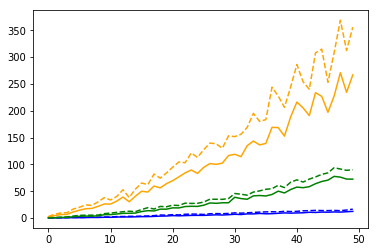

In [301]:
plt.plot(np.mean(T_scipy, axis=1),color='blue')
plt.plot(np.mean(T_scipy, axis=1)+np.std(T_scipy, axis=1),color='blue',linestyle='--')

plt.plot(np.mean(T_pytorch_gpu, axis=1),color='orange')
plt.plot(np.mean(T_pytorch_gpu, axis=1)+np.std(T_pytorch_gpu, axis=1),color='orange',linestyle='--')

plt.plot(np.mean(T_pytorch_cpu, axis=1),color='green')
plt.plot(np.mean(T_pytorch_cpu, axis=1)+np.std(T_pytorch_cpu, axis=1),color='green',linestyle='--')

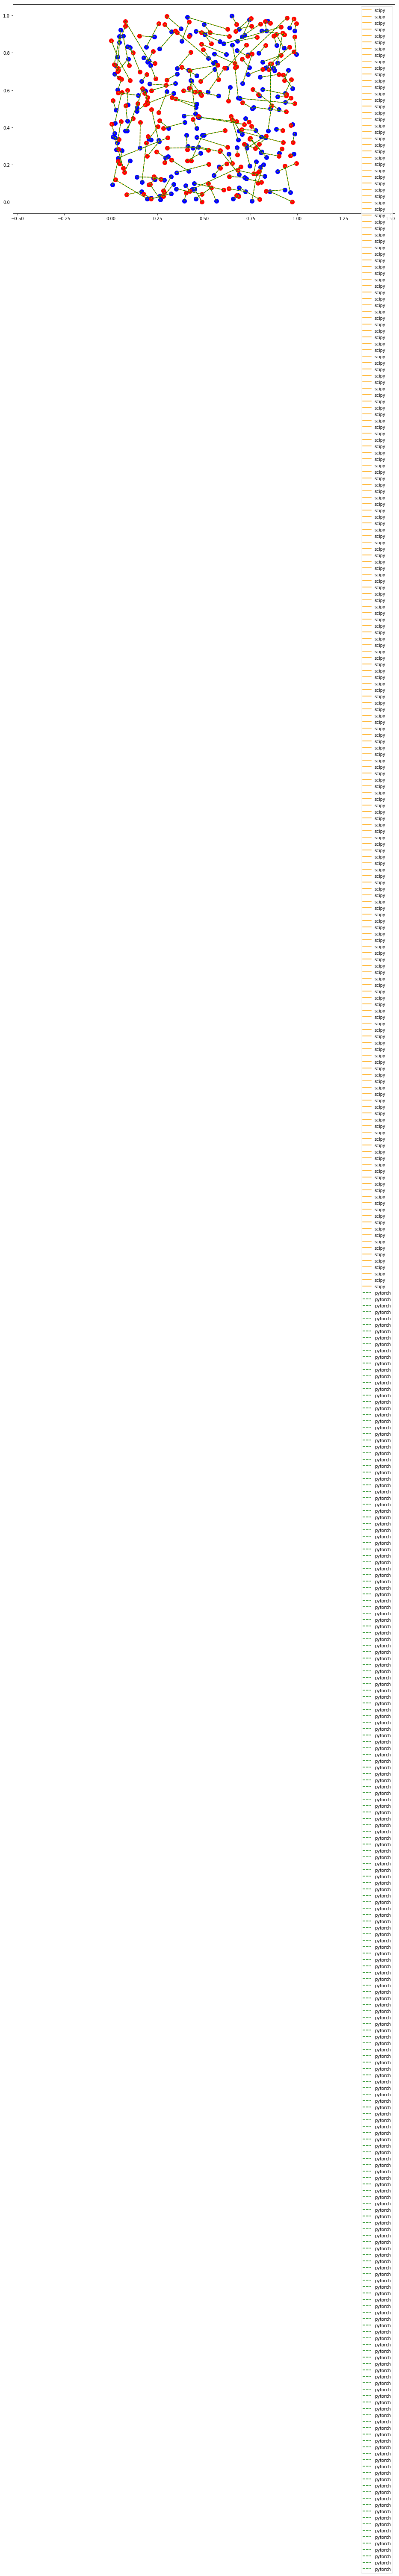

In [309]:
i = np.random.randint(prediction.shape[0])

g = prediction[i].cpu().numpy()
t = target[i].cpu().numpy()

D = sp.spatial.distance_matrix(g, t)
_, A_cols = sp.optimize.linear_sum_assignment(D)

D = torch.tensor(D)
A = hungarian(D).argmax(0).cpu().numpy()

plt.figure(figsize=(16,9))
plt.axis('equal')

plt.plot([g[:, 0], t[A_cols, 0]],
         [g[:, 1], t[A_cols, 1]],
         color='orange', label='scipy')

plt.plot([g[A, 0], t[:, 0]],
         [g[A, 1], t[:, 1]],
         color='green', linestyle='dashed', label='pytorch')
    
plt.scatter(g[:, 0], g[:, 1], color='blue', s=100)
plt.scatter(t[:, 0], t[:, 1], color='red', s=100)
    
plt.legend()
plt.show()